### 1. Setup and Model Definition

This section imports necessary libraries and defines the SNN architecture (Net class) using Leaky Integrate-and-Fire (LIF) neurons.

In [ ]:
import numpy as np 
import pandas as pd

from matplotlib import pyplot as plt
import snntorch as snn

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import random
import torch.backends.cudnn as cudnn

from ast import literal_eval

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

class Net(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, beta, thres):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, threshold=thres, learn_beta=True, learn_threshold=False)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, threshold=thres, learn_beta=True, learn_threshold=False)

    def forward(self, x, num_steps=25):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)


### 2. Data Loading and Preprocessing
The data is loaded from two CSV files (input_x8.csv and eskin_x8_v4.csv). The columns containing lists (like base_H, multigap_V) are parsed using literal_eval. Data from df2 is marked as a specific test set (test2) and concatenated with df.

In [ ]:
# Step 1: Load Data
# Load the first dataset ('input_x8.csv')
df = pd.read_csv('input_x8.csv', converters={'base_H': literal_eval, 'base_V': literal_eval,
                                             'multigap_H': literal_eval, 'multigap_V': literal_eval})

# Extract 'class' label from 'caseid' (assuming format like '..._X.csv' where X is the class label + 1)
df['class'] = df['caseid'].apply(lambda x: x.split('_')[5])
df['class'] = df['class'].apply(lambda x: int(x.split('.')[0])-1) # Convert to 0-indexed class

# Load the second dataset ('eskin_x8_v4.csv') - treated as an additional test set
df2 = pd.read_csv('eskin_x8.csv', converters={'base_H': literal_eval, 'base_V': literal_eval,
                                             'multigap_H': literal_eval, 'multigap_V': literal_eval})

# Assign 'test2' split and use 'true_label' for class
df2['split'] = 'test2'
df2['class'] = df2['true_label']

# Combine the two dataframes
df = pd.concat([df, df2]).reset_index(drop=True)

# Step 2: Prepare Features (X) and Labels (Y)
# The selected features for SNN training (try1: 'gap_H', 'gap_V' - core amplitude features)
# This code block selects 'gap_H' and 'gap_V' as a 2-feature vector for each sample.
X = torch.tensor(df[['gap_H', 'gap_V']].apply(lambda x: [x.tolist()], axis=1).tolist(), dtype=torch.float)

# Prepare labels (Y) as a tensor
Y = torch.tensor(df['class'].tolist(), dtype=torch.int64)

### 3. Hyperparameters and Data Splitting
Hyperparameters are set, and the combined dataset (df) is split into Train, Validation (eval), and three Test sets (test, test2, and a combined test3).

In [ ]:
# Hyperparameters
beta = 0.95 # Leakage factor for LIF neurons
thres = 0.8 # Firing threshold for LIF neurons
num_inputs1 = X.shape[2] # Input dimension (2 features: gap_H, gap_V)
num_outputs1 = 8  # Number of classes
learning_rate = 1e-3
num_epochs=500
num_steps = 15 # Simulation time steps
num_hidden1 = 15 # Number of neurons in the hidden layer
batch_size = 100
div = 5 # Interval for printing training status

# Data splitting masks based on the 'split' column
train_mask = df.split == 'train'
val_mask = df.split == 'eval'
test_mask1 = df.split == 'test'      # Conventional sensor test set (original)
test_mask2 = df.split == 'test2'     # E-skin sensor test set (df2)
test_mask3 = df.split.isin(['test', 'test2']) # Combined test set

# Apply masks to features and labels
trainX, trainY = X[train_mask], Y[train_mask]
valX, valY = X[val_mask], Y[val_mask]
testX1, testY1 = X[test_mask1], Y[test_mask1]
testX2, testY2 = X[test_mask2], Y[test_mask2]
testX3, testY3 = X[test_mask3], Y[test_mask3]

# Move data to the selected device (GPU/CPU)
trainX = trainX.to(DEVICE)
trainY = trainY.to(DEVICE)
valX = valX.to(DEVICE)
valY = valY.to(DEVICE)
testX1 = testX1.to(DEVICE)
testY1 = testY1.to(DEVICE)
testX2 = testX2.to(DEVICE)
testY2 = testY2.to(DEVICE)
testX3 = testX3.to(DEVICE)
testY3 = testY3.to(DEVICE)

# Set seeds for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

### 4. SNN Training and Evaluation
The SNN model is instantiated, loss function (Cross Entropy) and optimizer (Adam) are defined, and the training loop is executed.

In [ ]:
modelX = Net(num_inputs1, num_hidden1, num_outputs1, beta, thres).to(DEVICE)
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(modelX.parameters(), lr=learning_rate, betas=(0.9, 0.999))

train_dataset = TensorDataset(trainX, trainY)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

def calculate_accuracy(X, Y):
    modelX.eval()
    with torch.no_grad():
        spk_rec, _ = modelX(X.view(len(X), -1), num_steps)
        _, pred = spk_rec.sum(dim=0).max(1)
        correct = (pred == Y).sum().item()
        accuracy = correct / len(Y) * 100
    return accuracy

train_accuracies = []
eval_accuracies = []
test_accuracies1 = []
test_accuracies2 = []
train_losses = []  

for epoch in range(num_epochs):
    modelX.train()
    correct_train = 0
    total_train = 0
    epoch_loss = 0  
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        spk_rec, mem_rec = modelX(inputs.view(batch_size, -1), num_steps)
        loss_val = torch.zeros((1), dtype=torch.float, device=DEVICE)

        for step in range(num_steps):
            loss_val += loss_function(spk_rec[step], targets)
        
        optimizer.zero_grad() 
        loss_val.backward() 
        optimizer.step()

        epoch_loss += loss_val.item()  
        _, predicted = spk_rec.sum(dim=0).max(1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_accuracy = 100 * correct_train / total_train
    eval_accuracy = calculate_accuracy(valX, valY)
    test_accuracy1 = calculate_accuracy(testX1, testY1)
    test_accuracy2 = calculate_accuracy(testX2, testY2)
    test_accuracy3 = calculate_accuracy(testX3, testY3)

    # 시각화 데이터 저장
    train_accuracies.append(train_accuracy)
    eval_accuracies.append(eval_accuracy)
    test_accuracies1.append(test_accuracy1)
    test_accuracies2.append(test_accuracy2)
    train_losses.append(epoch_loss)  

    if ((epoch + 1) % div == 0) and (epoch > 0):  # Add this line
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, "
            f"Train: {train_accuracy:.2f}%, Eval: {eval_accuracy:.2f}%, Test1: {test_accuracy1:.2f}%, Test2: {test_accuracy2:.2f}%, Test3: {test_accuracy3:.2f}%")

Epoch 5/500, Loss: 454.7505, Train: 49.25%, Eval: 57.19%, Test1: 55.94%, Test2: 54.17%, Test3: 55.73%
Epoch 10/500, Loss: 382.4127, Train: 69.31%, Eval: 70.53%, Test1: 70.72%, Test2: 66.67%, Test3: 70.23%
Epoch 15/500, Loss: 361.7926, Train: 79.31%, Eval: 82.81%, Test1: 79.42%, Test2: 70.83%, Test3: 78.37%
Epoch 20/500, Loss: 353.8068, Train: 80.06%, Eval: 83.51%, Test1: 79.42%, Test2: 79.17%, Test3: 79.39%
Epoch 25/500, Loss: 351.1430, Train: 80.56%, Eval: 83.86%, Test1: 79.42%, Test2: 81.25%, Test3: 79.64%
Epoch 30/500, Loss: 343.0718, Train: 93.12%, Eval: 96.84%, Test1: 95.65%, Test2: 93.75%, Test3: 95.42%
Epoch 35/500, Loss: 324.2349, Train: 95.62%, Eval: 95.44%, Test1: 95.94%, Test2: 93.75%, Test3: 95.67%
Epoch 40/500, Loss: 322.0819, Train: 95.44%, Eval: 95.09%, Test1: 95.94%, Test2: 93.75%, Test3: 95.67%
Epoch 45/500, Loss: 319.6585, Train: 95.69%, Eval: 95.09%, Test1: 95.94%, Test2: 93.75%, Test3: 95.67%
Epoch 50/500, Loss: 318.6808, Train: 95.38%, Eval: 94.74%, Test1: 96.23%, 

### 5. SNN Visualization (Accuracy & Loss)
This section defines and executes a function to plot the training and evaluation metrics over the epochs.

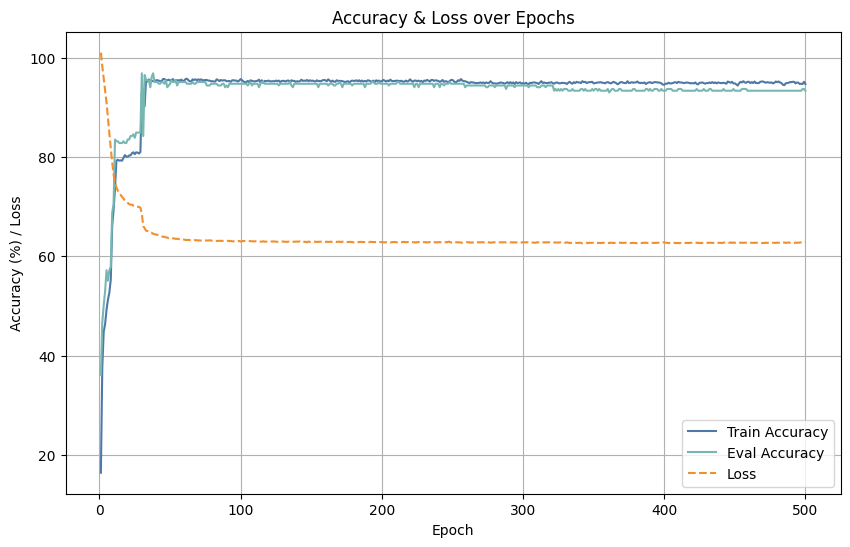

In [ ]:

def plot_results(num_epochs,train_accuracies, eval_accuracies, train_losses, train_color='blue', eval_color='green', test_color='red', loss_color='purple'):
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(10, 6))

    # Plot accuracies
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color=train_color, marker='')
    plt.plot(epochs, eval_accuracies, label='Eval Accuracy', color=eval_color, marker='')
    # plt.plot(epochs, test_accuracies1, label='Test (Conventional sensor) Accuracy', color='purple', marker='')

    plt.plot(epochs, train_losses, label='Loss', color=loss_color, linestyle='--')

    plt.title('Accuracy & Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%) / Loss')
    plt.legend(loc='best')
    plt.grid(True)

    plt.show()

xlen = 500
plot_results(xlen,train_accuracies[0:xlen], eval_accuracies[0:xlen],[i/5 for i in train_losses[0:xlen]], 
             train_color='#4e79a7', eval_color='#76b7b2', test_color='#e15759', loss_color='#f28e2b')

Confusion Matrix for Train set
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       180
           1       0.98      0.98      0.98       190
           2       0.99      0.98      0.98       223
           3       0.94      0.91      0.92       158
           4       0.84      0.95      0.89       182
           5       0.97      0.92      0.95       280
           6       0.97      0.97      0.97       241
           7       0.95      0.97      0.96       186

    accuracy                           0.95      1640
   macro avg       0.95      0.95      0.95      1640
weighted avg       0.96      0.95      0.95      1640



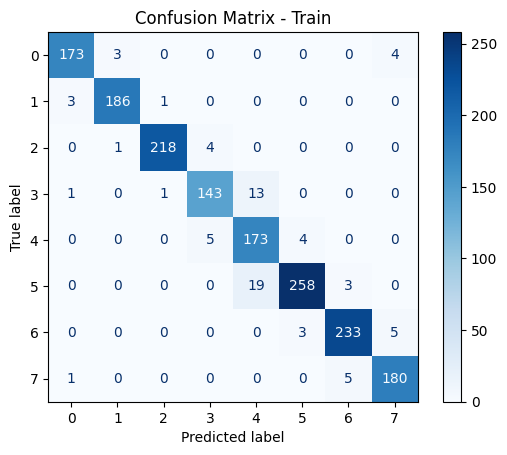

Confusion Matrix for Eval set
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        37
           1       0.95      1.00      0.97        37
           2       1.00      1.00      1.00        31
           3       0.86      1.00      0.93        32
           4       0.93      0.84      0.89        32
           5       1.00      0.94      0.97        35
           6       1.00      0.97      0.99        35
           7       0.98      0.89      0.93        46

    accuracy                           0.95       285
   macro avg       0.95      0.95      0.95       285
weighted avg       0.95      0.95      0.95       285



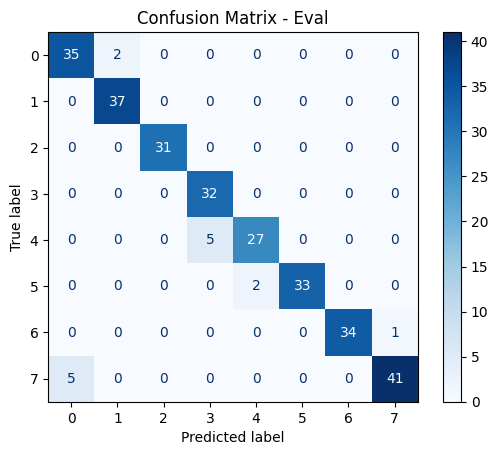

Confusion Matrix for Test set (Conventional sensor) set
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        36
           1       0.96      1.00      0.98        23
           2       1.00      0.97      0.99        36
           3       0.96      0.98      0.97        48
           4       0.88      0.98      0.92        44
           5       0.95      0.91      0.93        64
           6       0.97      0.95      0.96        60
           7       1.00      0.91      0.95        34

    accuracy                           0.95       345
   macro avg       0.96      0.96      0.96       345
weighted avg       0.96      0.95      0.95       345



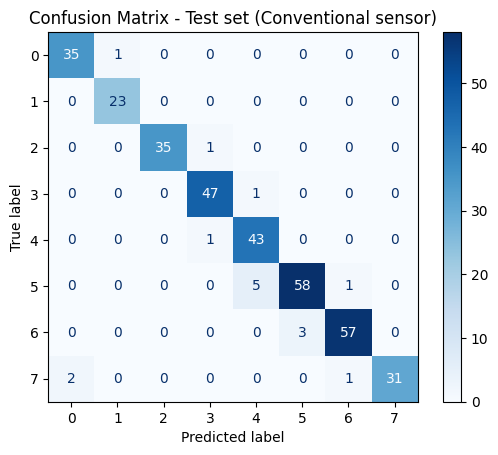

Confusion Matrix for Test set (E-skin) set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.83      0.91         6
           2       1.00      1.00      1.00         6
           3       0.83      0.83      0.83         6
           4       0.71      0.83      0.77         6
           5       1.00      0.83      0.91         6
           6       0.86      1.00      0.92         6
           7       1.00      1.00      1.00         6

    accuracy                           0.92        48
   macro avg       0.93      0.92      0.92        48
weighted avg       0.93      0.92      0.92        48



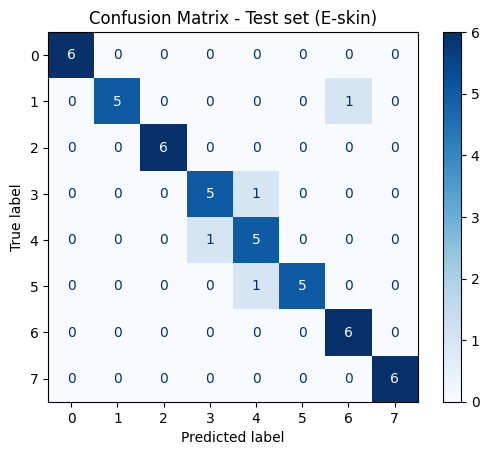

In [ ]:
def generate_confusion_matrix(X, Y, set_name):
    with torch.no_grad():
        modelX.eval()
        spk_rec, _ = modelX(X.view(len(X), -1), num_steps)
        _, pred = spk_rec.sum(dim=0).max(1)
        pred = pred.to('cpu').numpy()
        true = Y.to('cpu').numpy()

        conf_matrix = confusion_matrix(true, pred)
        print(f"Confusion Matrix for {set_name} set")
        print(classification_report(true, pred))

        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix - {set_name}')
        plt.show()

generate_confusion_matrix(trainX, trainY, "Train")
generate_confusion_matrix(valX, valY, "Eval")
generate_confusion_matrix(testX1, testY1, "Test set (Conventional sensor)")
generate_confusion_matrix(testX2, testY2, "Test set (E-skin)")